## Dependencies

In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import normalize
import jax
import tensornetwork as tn
import quimb as qu
import quimb.tensor as qtn
import util
from collections import defaultdict
import seaborn as sns; sns.set(
    rc = {'figure.figsize':(18,2)},
    font="monospace"
    )
import my_tn

# Basics (Bradley)

In [177]:
d = 3
s = np.eye(d)
v = np.random.random(d)
π =  v / v.sum()
π

array([0.07031251, 0.48982608, 0.43986141])

In [178]:
ρ_diag = np.diag(π)
ρ_diag

array([[0.07031251, 0.        , 0.        ],
       [0.        , 0.48982608, 0.        ],
       [0.        , 0.        , 0.43986141]])

In [179]:
ψ = np.sum([np.sqrt(π[i])*s[i] for i in range(d)],axis=0)
ψ

array([0.26516506, 0.69987576, 0.66322049])

In [180]:
np.inner(ψ,ψ)

1.0

In [181]:
ρ_π = np.outer(ψ,ψ)
ρ_π

array([[0.07031251, 0.1855826 , 0.1758629 ],
       [0.1855826 , 0.48982608, 0.46417194],
       [0.1758629 , 0.46417194, 0.43986141]])

In [182]:
i = 2
np.inner(s[i],ψ)*np.inner(ψ,s[i])

0.43986141298528325

In [183]:
np.tensordot(ψ,ψ,axes = 0)

array([[0.07031251, 0.1855826 , 0.1758629 ],
       [0.1855826 , 0.48982608, 0.46417194],
       [0.1758629 , 0.46417194, 0.43986141]])

In [184]:
print(np.linalg.matrix_rank(ρ_diag))
print(np.linalg.matrix_rank(ρ_π))

3
1


In [185]:
# von Neumann entropy

-np.trace(ρ_π * np.log(ρ_π))

0.8975135424314884

In [186]:
ρ = ρ_diag

ρ = np.array([
    [1/3,1/3,0],
    [1/3,1/3,0],
    [0,0,1/3]
    ])

ρ_rank = np.linalg.matrix_rank(ρ)
print(ρ_rank)
if ρ_rank>1:
    λ,e = np.linalg.eigh(ρ)
    print(f"Eigenvalues: {λ}")
    print(f"Eigenvectors:\n {e}")
    spectral_decomposition = np.array([λ[i]*np.outer(e[i],e[i]) for i in range(ρ_rank)])
    print(f"Spectral decomposition:\n{spectral_decomposition}")
    print(f"ρ:\n{np.add.reduce(spectral_decomposition)}")


2
Eigenvalues: [0.         0.33333333 0.66666667]
Eigenvectors:
 [[-0.70710678  0.          0.70710678]
 [ 0.70710678  0.          0.70710678]
 [ 0.          1.          0.        ]]
Spectral decomposition:
[[[ 0.         -0.         -0.        ]
  [-0.          0.          0.        ]
  [-0.          0.          0.        ]]

 [[ 0.16666667  0.          0.16666667]
  [ 0.          0.          0.        ]
  [ 0.16666667  0.          0.16666667]]]
ρ:
[[0.16666667 0.         0.16666667]
 [0.         0.         0.        ]
 [0.16666667 0.         0.16666667]]


In [187]:
ρ

array([[0.33333333, 0.33333333, 0.        ],
       [0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

## Partial Trace

In [188]:
V = ["o","g","p"]
W = ["F","V"]
dim_V = len(V)
dim_W = len(W)
VxW = [v+w for w in W for v in V]
VxW

['oF', 'gF', 'pF', 'oV', 'gV', 'pV']

In [189]:
d = len(VxW)
s = np.eye(d)
v = np.random.random(d)
v = np.array([1/3,1/3,0,0,0,1/3])

joint_prob = {k:v for k,v in zip(VxW,v)}


In [190]:
M_raw = np.array([[joint_prob[v+w] for w in W] for v in V])
M_norm = M_raw/M_raw.sum()
M = np.sqrt(M_norm)

In [191]:
# numpy reshapes arrays differently than Bradley, hence the "F" here
π =  M_norm.reshape(M_norm.size, order="F")
π

array([0.33333333, 0.33333333, 0.        , 0.        , 0.        ,
       0.33333333])

In [192]:
ψ = np.sum([np.sqrt(π[i])*s[i] for i in range(d)],axis=0)
ρ_π = np.outer(ψ,ψ)
print(ρ_π)

[[0.33333333 0.33333333 0.         0.         0.         0.33333333]
 [0.33333333 0.33333333 0.         0.         0.         0.33333333]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.         0.         0.         0.33333333]]


In [193]:
def Tr_Y(ρ,dim_V,dim_W):
    # numpy reshapes arrays differently than Bradley, hence the "F" here
    ρ_tensor = ρ.reshape((dim_V,dim_W,dim_V,dim_W), order = "F")
    Tr = np.trace(ρ_tensor, axis1=1, axis2=3)
    return Tr

def Tr_X(ρ,dim_V,dim_W):
    # numpy reshapes arrays differently than Bradley, hence the "F" here
    ρ_tensor = ρ.reshape((dim_V,dim_W,dim_V,dim_W), order = "F")
    Tr = np.trace(ρ_tensor, axis1=0, axis2=2)
    return Tr

In [194]:
ρ_X = Tr_Y(ρ_π,dim_V,dim_W)
ρ_Y = Tr_X(ρ_π,dim_V,dim_W)
print(ρ_X)
print(ρ_Y)

[[0.33333333 0.33333333 0.        ]
 [0.33333333 0.33333333 0.        ]
 [0.         0.         0.33333333]]
[[0.66666667 0.        ]
 [0.         0.33333333]]


In [195]:
ρ_X_eigvals, ρ_X_eigvec = np.linalg.eig(ρ_X)
ρ_Y_eigvals, ρ_Y_eigvec = np.linalg.eig(ρ_Y)

V,D,Ut = np.linalg.svd(M)

In [196]:
ρ_X_eigvals

array([0.66666667, 0.        , 0.33333333])

In [197]:
D**2

array([0.66666667, 0.33333333])

In [198]:
M.dot(M.T)

array([[0.33333333, 0.33333333, 0.        ],
       [0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

In [199]:
ρ_X

array([[0.33333333, 0.33333333, 0.        ],
       [0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

In [200]:
M**2

array([[0.33333333, 0.        ],
       [0.33333333, 0.        ],
       [0.        , 0.33333333]])

In [201]:
(ρ_Y_eigvec**2)*(ρ_Y_eigvals)

array([[0.66666667, 0.        ],
       [0.        , 0.33333333]])

In [202]:
V**2.dot(np.diag())

SyntaxError: invalid syntax (<ipython-input-202-b25ad7328957>, line 1)

In [ ]:
ρ_Y_eigvec

array([[1., 0.],
       [0., 1.]])

In [ ]:
Ut

array([[-1., -0.],
       [-0., -1.]])

In [ ]:
np.linalg.eig(M.dot(M.T))

(array([0.66666667, 0.        , 0.33333333]),
 array([[ 0.70710678, -0.70710678,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]))

In [ ]:
np.linalg.eig(M.T.dot(M))

(array([6.72757346e-01, 8.55738255e-02, 5.27168581e-02, 2.47960623e-02,
        2.21650754e-02, 1.90736064e-02, 1.64958122e-02, 1.58124751e-02,
        1.30332290e-02, 1.05433943e-02, 1.02389763e-02, 8.37359580e-03,
        7.64346305e-03, 6.88687210e-03, 5.61514301e-03, 4.54050860e-03,
        3.96320526e-03, 3.84640502e-03, 3.09966512e-03, 2.80697645e-03,
        2.49828116e-03, 1.72953735e-03, 1.60457890e-03, 1.06256948e-03,
        8.42271754e-04, 7.43530827e-04, 4.69097085e-04, 3.63431666e-04,
        3.06369117e-04, 1.35991459e-04, 1.16048398e-04, 7.15967993e-05,
        5.69595180e-05, 8.20503972e-06, 4.67684772e-06, 3.52237574e-07,
        1.09501616e-09, 1.95270760e-08, 1.66436725e-06, 2.32173659e-06]),
 array([[ 0.15244584, -0.07826185, -0.07422974, ...,  0.04396804,
         -0.00940865,  0.00033844],
        [ 0.20985708, -0.06661256, -0.05943162, ..., -0.08330022,
          0.01133257, -0.00812765],
        [ 0.30205213,  0.02455748, -0.02099579, ..., -0.0048299 ,
        

## Application to Wikipedia

In [4]:
# Functions

def Tr_Y(ρ,dim_V,dim_W):
    # numpy reshapes arrays differently than Bradley, hence the "F" here
    ρ_tensor = ρ.reshape((dim_V,dim_W,dim_V,dim_W), order = "F")
    Tr = np.trace(ρ_tensor, axis1=1, axis2=3)
    return Tr

def Tr_X(ρ,dim_V,dim_W):
    # numpy reshapes arrays differently than Bradley, hence the "F" here
    ρ_tensor = ρ.reshape((dim_V,dim_W,dim_V,dim_W), order = "F")
    Tr = np.trace(ρ_tensor, axis1=0, axis2=2)
    return Tr

In [62]:
path_data = "./data/"
punctuation = " \n\t.,;:|()[]\{\}\xa0'’‘\"”“?!"

ng1_raw = util.load_file(path_data + "1_10.json")
ng2_raw = util.load_file(path_data + "2_10.json")
ng3_raw = util.load_file(path_data + "3_10.json")

ng1 = defaultdict(int)
for k,v in ng1_raw.items():
    if k not in punctuation:
        ng1[k.lower()] += v
        
ng2 = defaultdict(int)
for (kl,kr),v in ng2_raw.items():
    if kl not in punctuation and kr not in punctuation:
        ng2[(kl+kr).lower()] += v

ng3 = defaultdict(int)
for (kl,kc,kr),v in ng3_raw.items():
    if kl not in punctuation and kc not in punctuation and kr not in punctuation:
        ng3[(kl+kc+kr).lower()] += v

In [63]:
e_len = 40
elements = [k for k,v in ng1.items()][:e_len]# + ["+","<",">","×"]

# elements = [str(n) for n in range(1,10)]

elements = sorted(elements)
elements_dict = {k:i for i,k in enumerate(elements)}


print(elements)

['-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '–']


In [64]:
V = elements
W = elements
dim_V = len(V)
dim_W = len(W)
VxW = [v+w for w in W for v in V]

In [65]:
cond = "m"
ng2_cond = {k[1:]:v for k,v in ng3.items() if k[0]==cond}

In [9]:
d = len(VxW)
s = np.eye(d)

# joint_prob = {dd:np.log10(1+1/int(dd)) for dd in VxW }
joint_prob = ng2
# joint_prob = ng2_cond
joint_prob = {k:v for i,(k,v) in enumerate(ng2.items()) if i>50}

In [67]:
M_raw = np.array([[joint_prob.get(v+w,0) for w in W] for v in V])

total = sum([ng1[e] for e in elements])
M_pmi = util.pmi_matrix(elements,elements,ng1,ng2,ng2,total,independent=False)
M_pmi_pos = M_pmi.copy()
M_pmi_neg = M_pmi.copy()
M_pmi_pos[M_pmi_pos < 0] = 0
M_pmi_neg[M_pmi_neg > 0] = 0
M_pmi_neg = -M_pmi_neg
M_sppmi = util.pmi(M_raw).toarray()
M_sppmi_norm = M_sppmi/M_sppmi.sum()

M_norm = M_raw/M_raw.sum()
M_pmi_p_norm = M_pmi_pos/M_pmi_pos.sum()
M_pmi_n_norm = M_pmi_neg/M_pmi_neg.sum()

Done


In [11]:
M_norm = M_norm
# M_norm = M_sppmi_norm
M = np.emath.sqrt(M_norm)

In [68]:
# numpy reshapes arrays differently than Bradley, hence the "F" here
π =  M_norm.flatten('F')
ψ = np.sum([np.emath.sqrt(π[i])*s[i] for i in range(d)],axis=0)
ρ_π = np.outer(ψ,ψ)
ρ_X = Tr_Y(ρ_π,dim_V,dim_W)
ρ_Y = Tr_X(ρ_π,dim_V,dim_W)

In [69]:
ρ_X_eigvals, ρ_X_eigvec = np.linalg.eig(ρ_X)
ρ_Y_eigvals, ρ_Y_eigvec = np.linalg.eig(ρ_Y)

idx = ρ_X_eigvals.argsort()[::-1]   
ρ_X_eigvals = ρ_X_eigvals[idx]
ρ_X_eigvec = ρ_X_eigvec[:,idx]

idx = ρ_Y_eigvals.argsort()[::-1]   
ρ_Y_eigvals = ρ_Y_eigvals[idx]
ρ_Y_eigvec = ρ_Y_eigvec[:,idx]

In [14]:
# # For comparison of SVD with reduced densities

# ax = sns.heatmap([ρ_X_eigvals[:bond_size]], annot=True)

# util.plot(ρ_X_eigvec.T[:bond_size]
# *(np.sign(Ut[:,0])*np.sign(ρ_X_eigvec.T[:bond_size][:,0])).reshape(bond_size,1)
# , elements, [f"Tr{i+1}" for i in range(bond_size)])#,yticklabels=None)

# util.plot(ρ_Y_eigvec.T[:bond_size]
# *(np.sign(V.T[:,0])*np.sign(ρ_Y_eigvec.T[:bond_size][:,0])).reshape(bond_size,1)
# , elements, [f"Tl{i+1}" for i in range(bond_size)])#,yticklabels=None)

## SVD

In [75]:
V,D,Ut = np.linalg.svd(M.T)
bond_size = 6
type_labels = [f"T{i+1}" for i in range(bond_size)]
type_labels_l = [f"Tl{i+1}" for i in range(bond_size)]
type_labels_r = [f"Tr{i+1}" for i in range(bond_size)]
V = V[:,:bond_size]
D = D[:bond_size]
Ut = Ut[:bond_size]

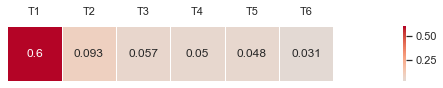

In [82]:
sns.set(rc = {'figure.figsize':(25,1)})
util.plot([D**2], type_labels, [], annot=True)

In [85]:
Ut_p = Ut.copy()
Ut_p[Ut_p<0]=0
Ut_n = -Ut.copy()
Ut_n[Ut_n<0]=0
V_p = V.copy()
V_p[V_p<0]=0
V_n = -V.copy()
V_n[V_n<0]=0


L_svd = Ut
R_svd = V.T

L_svd_pn = np.vstack([Ut_p,Ut_n])**2
R_svd_pn = np.vstack([V_p.T,V_n.T])**2

## Eigen on PMI

In [91]:
ρ_L = M_pmi@M_pmi.T
ρ_R = M_pmi.T@M_pmi

ρ_L_eigvals, ρ_L_eigvec = np.linalg.eig(ρ_L)
ρ_R_eigvals, ρ_R_eigvec = np.linalg.eig(ρ_R)

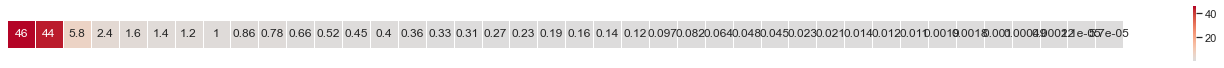

In [92]:
sns.set(rc = {'figure.figsize':(25,1)})
util.plot([ρ_L_eigvals], [], [], annot=True)

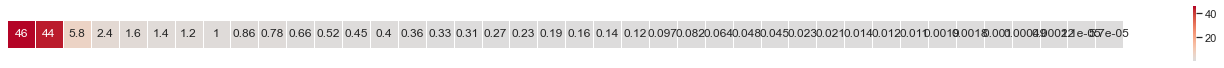

In [93]:
sns.set(rc = {'figure.figsize':(25,1)})
util.plot([ρ_R_eigvals], [], [], annot=True)

In [94]:
bond_size = 6
L_eig = ρ_L_eigvec.T[:bond_size]
R_eig = ρ_R_eigvec.T[:bond_size]

## Clustering

In [95]:
from sklearn.cluster import KMeans

In [96]:
bond_size = 4
kmeans_l = KMeans(n_clusters=bond_size, random_state=0).fit(M_pmi)
centroids_l = kmeans_l.cluster_centers_
L_kmeans = (M_pmi@centroids_l.T).T

kmeans_r = KMeans(n_clusters=bond_size, random_state=0).fit(M_pmi.T)
centroids_r = kmeans_r.cluster_centers_
R_kmeans = (M_pmi@centroids_r.T).T

## Tests

L


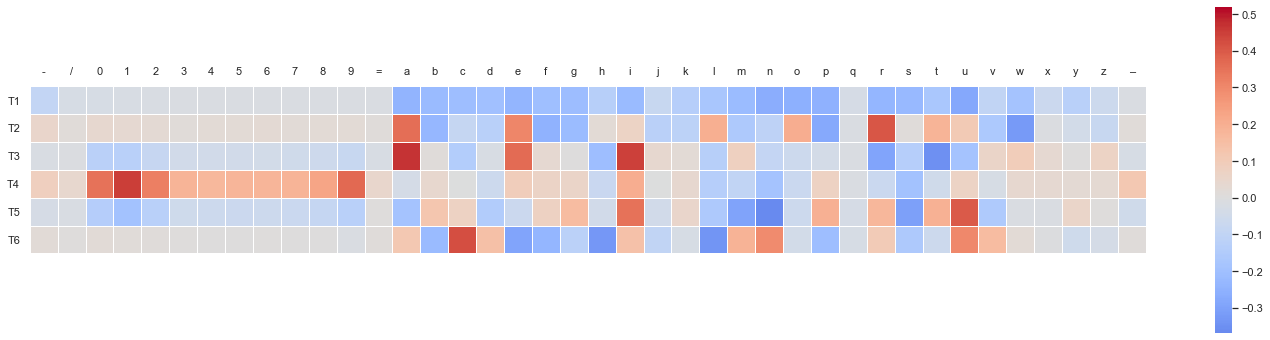

In [99]:
# # SVD


L = L_svd
R = R_svd

# L = L_svd_pn
# R = R_svd_pn

# # Eigen on PMI
# L = L_eig
# R = R_eig

# K-means
# L = L_kmeans
# R = R_kmeans



vmax = max([L.max(),R.max()])

type_labels = [f"T{i+1}" for i in range(L.shape[0])]

print("L")
sns.set(rc = {'figure.figsize':(25,6)})
util.plot(L, elements, type_labels,vmax = vmax)

R


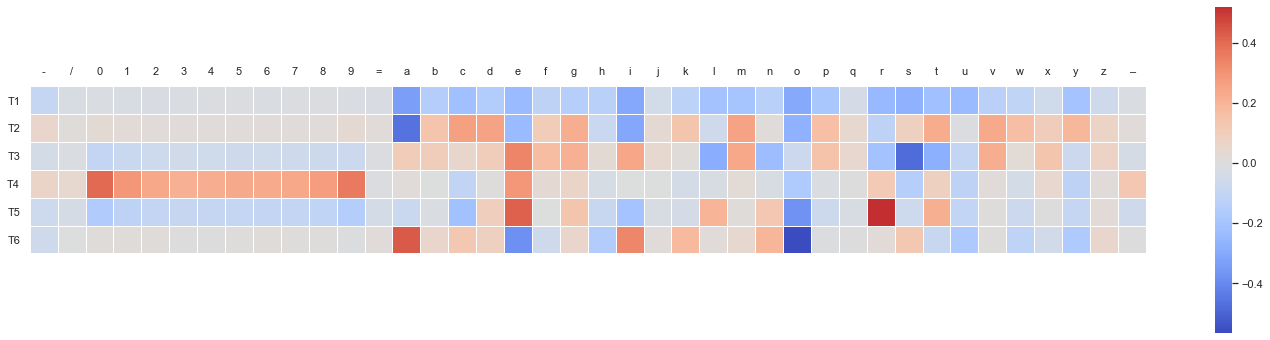

In [100]:
print("R")
util.plot(R, elements, type_labels,vmax = vmax)

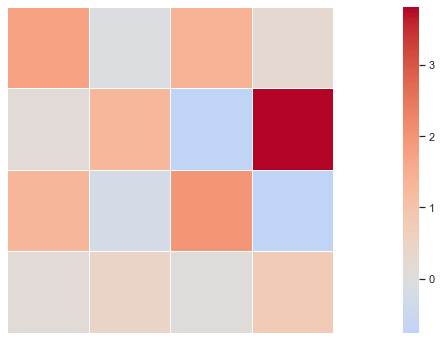

In [88]:
util.plot(centroids_r@centroids_l.T, [],[],vmax = None)

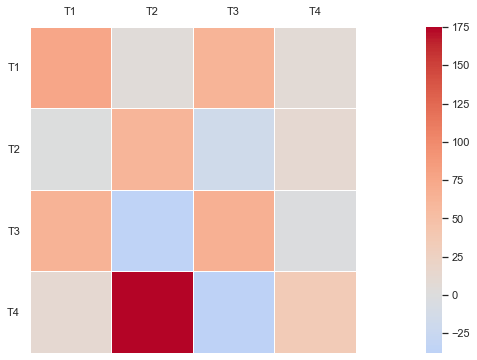

In [45]:
util.plot(L@R.T, type_labels, type_labels,vmax = None)

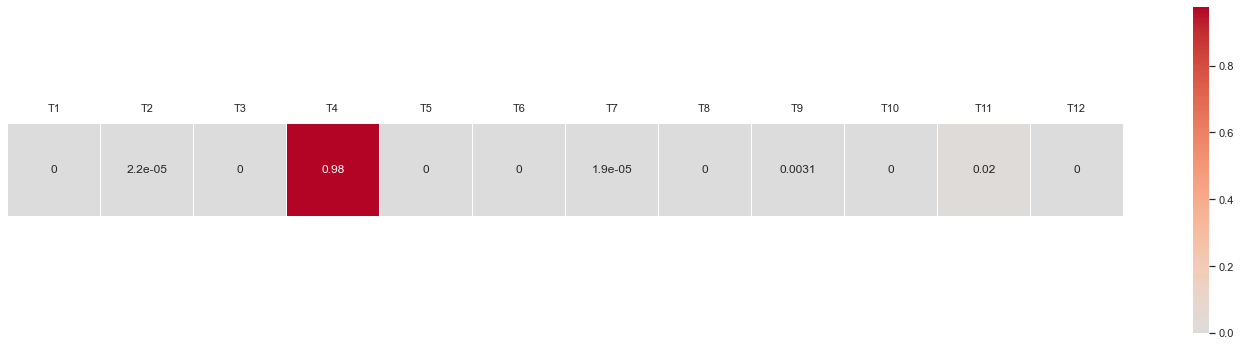

In [28]:
expression = "92"

expression_i = [elements_dict[char] for char in expression]
expression_input = np.eye(e_len)[expression_i]
type_vector = (L@expression_input[0])*(R@expression_input[1])#*D
type_vector_norm = type_vector/type_vector.sum()
type_bond = np.argmax(type_vector)
util.plot([type_vector_norm],type_labels,[],annot=True)

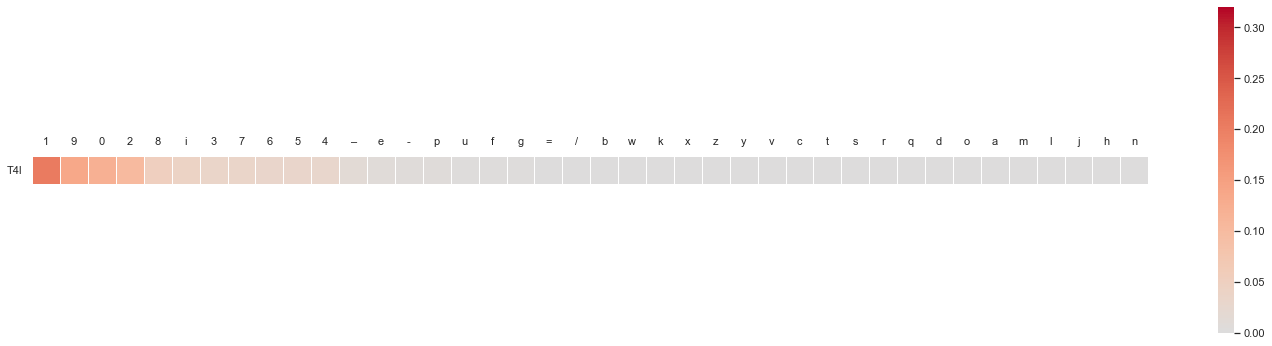

In [29]:
util.plot([-np.sort(-L[type_bond])],[elements[i] for i in np.argsort(-L[type_bond])],[f"T{type_bond+1}l"],vmax = vmax)


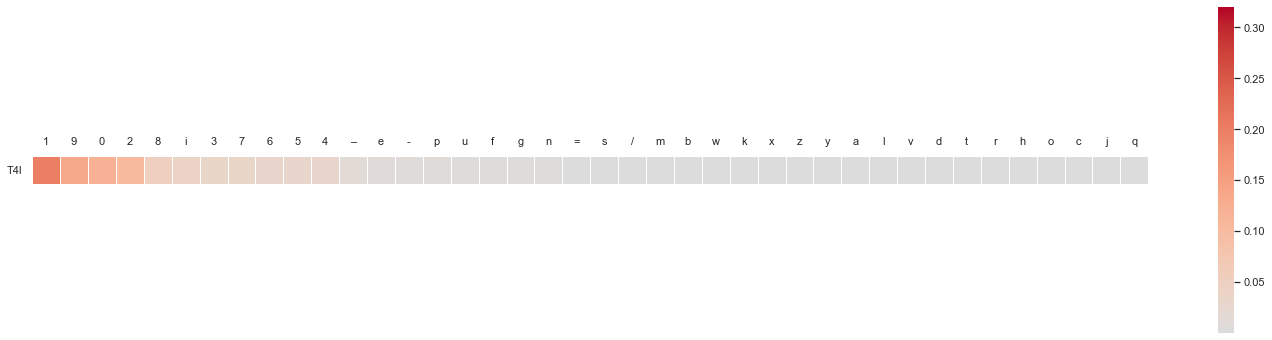

In [32]:
vector_parad_l = (L*(type_vector_norm.reshape(-1,1))).sum(axis=0)
util.plot([-np.sort(-vector_parad_l)],[elements[i] for i in np.argsort(-vector_parad_l)],[f"T{type_bond+1}l"],vmax = vmax)

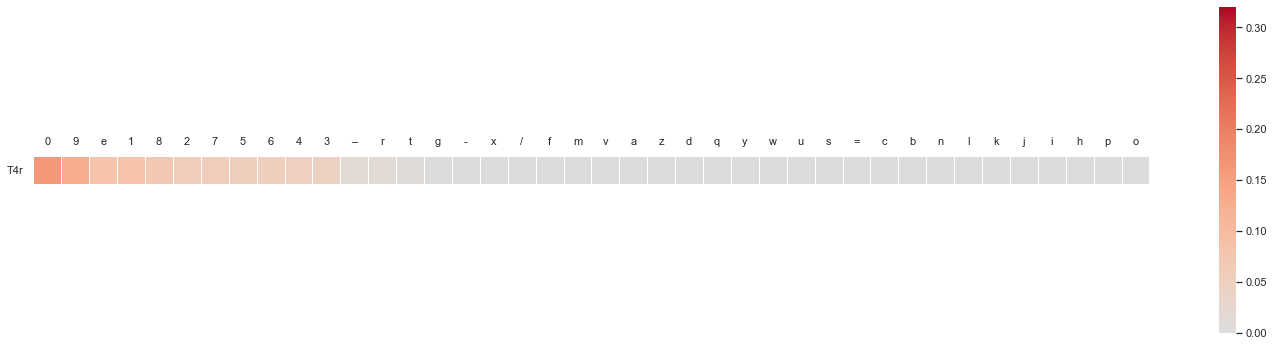

In [33]:
util.plot([-np.sort(-R[type_bond])],[elements[i] for i in np.argsort(-R[type_bond])],[f"T{type_bond+1}r"],vmax = vmax)

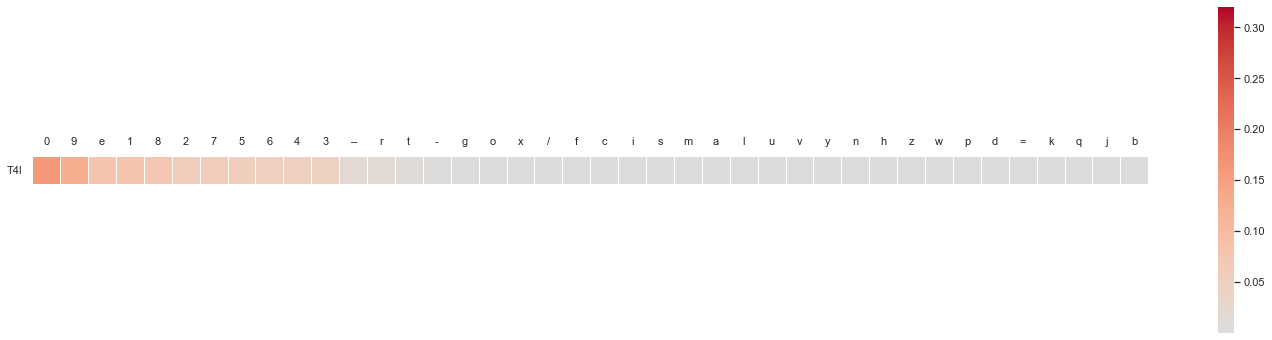

In [34]:
vector_parad_r = (R*(type_vector_norm.reshape(-1,1))).sum(axis=0)
util.plot([-np.sort(-vector_parad_r)],[elements[i] for i in np.argsort(-vector_parad_r)],[f"T{type_bond+1}l"],vmax = vmax)

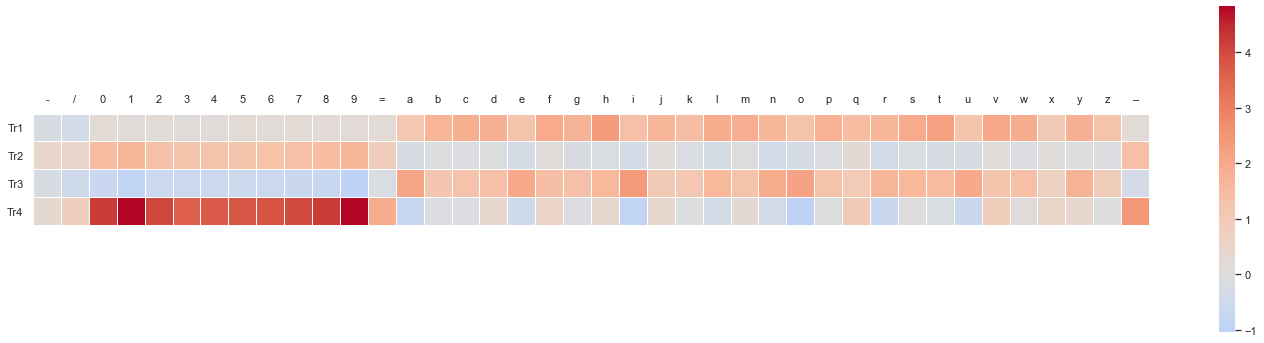

In [ ]:
sns.set(rc = {'figure.figsize':(25,6)})
util.plot(U_kmeans, elements, [f"Tr{i+1}" for i in range(bond_size)],vmax = vmax)

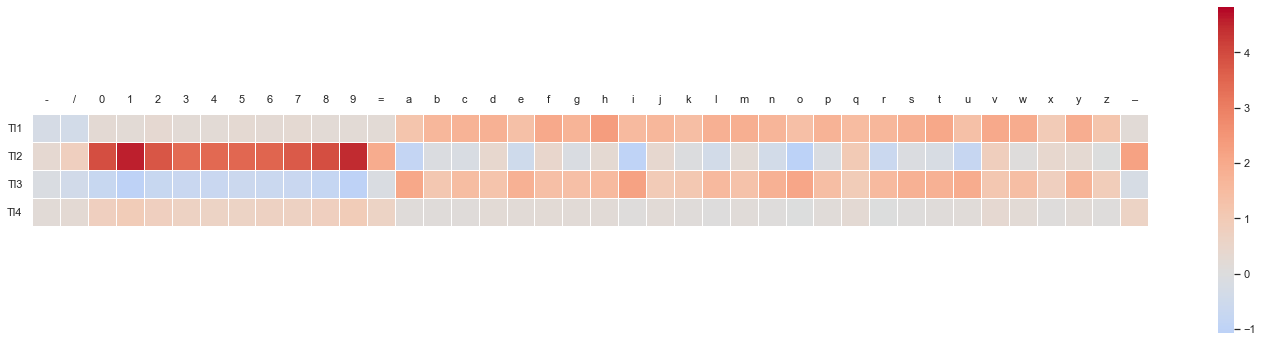

In [ ]:
util.plot(V_kmeans, elements, [f"Tl{i+1}" for i in range(bond_size)],vmax = vmax)

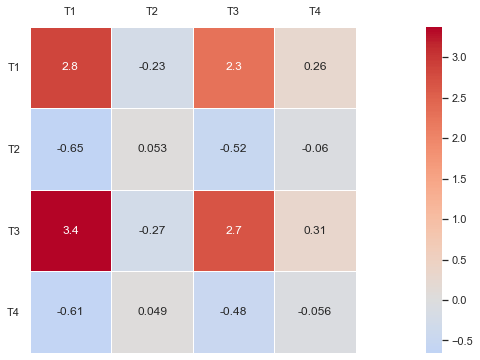

In [ ]:
expression = "ng"

expression_i = [elements_dict[char] for char in expression]
expression_input = np.eye(e_len)[expression_i]
# type_vector = (U_kmeans@expression_input[0])@((V_kmeans@expression_input[1]).T)#*D
type_vector = np.outer((U_kmeans@expression_input[0]),((V_kmeans@expression_input[1])))
type_bond = (np.argmax(np.max(type_vector, axis=1)),np.argmax(np.max(type_vector, axis=0)))
util.plot(type_vector,type_labels[:bond_size],type_labels[:bond_size],annot=True)

In [ ]:
L_rep_vector = (U_kmeans*((U_kmeans@expression_input[0]).reshape(-1,1))).sum(axis=0)

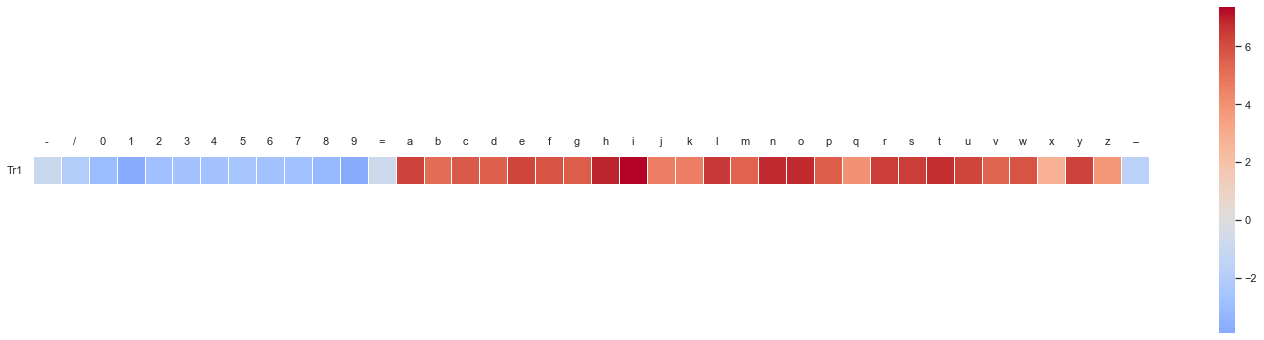

In [ ]:
sns.set(rc = {'figure.figsize':(25,6)})
util.plot(
    [L_rep_vector],
    elements, [f"Tr{i+1}" for i in range(1)],vmax = None)

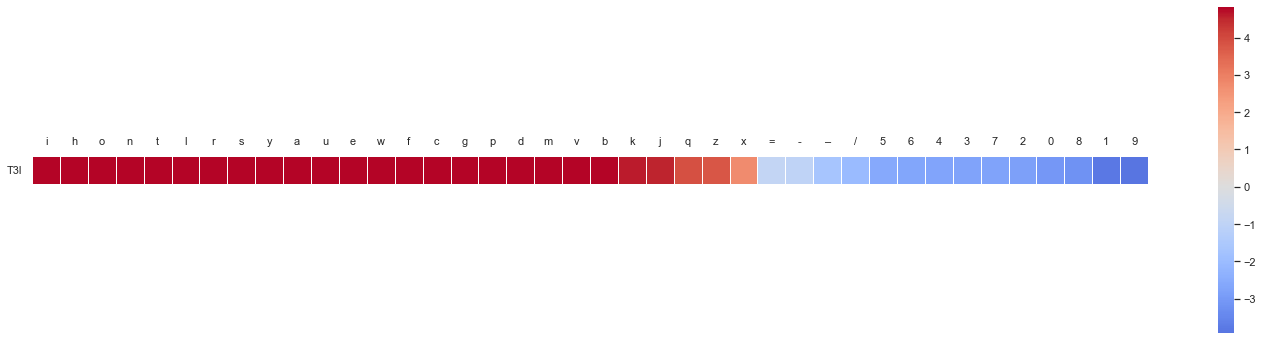

In [ ]:
util.plot([-np.sort(-L_rep_vector)],[elements[i] for i in np.argsort(-L_rep_vector)],[f"T{type_bond[0]+1}l"],vmax = vmax)

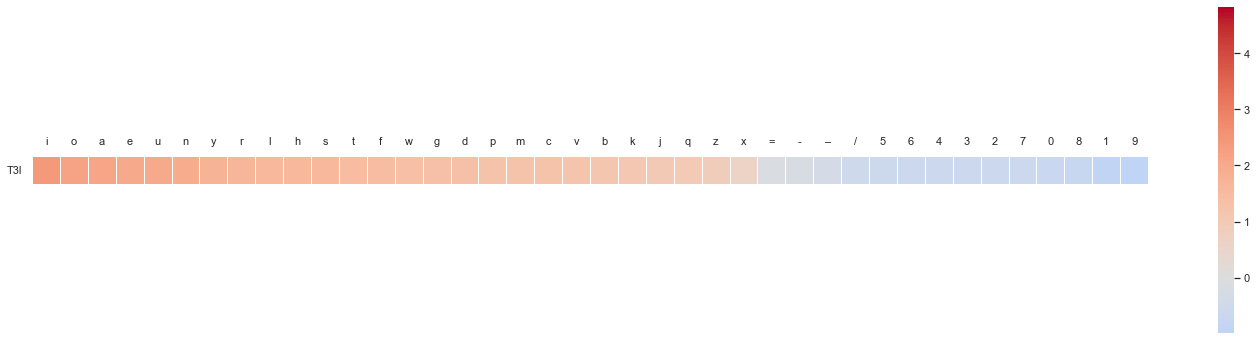

In [ ]:
util.plot([-np.sort(-U_kmeans[type_bond[0]])],[elements[i] for i in np.argsort(-U_kmeans[type_bond[0]])],[f"T{type_bond[0]+1}l"],vmax = vmax)

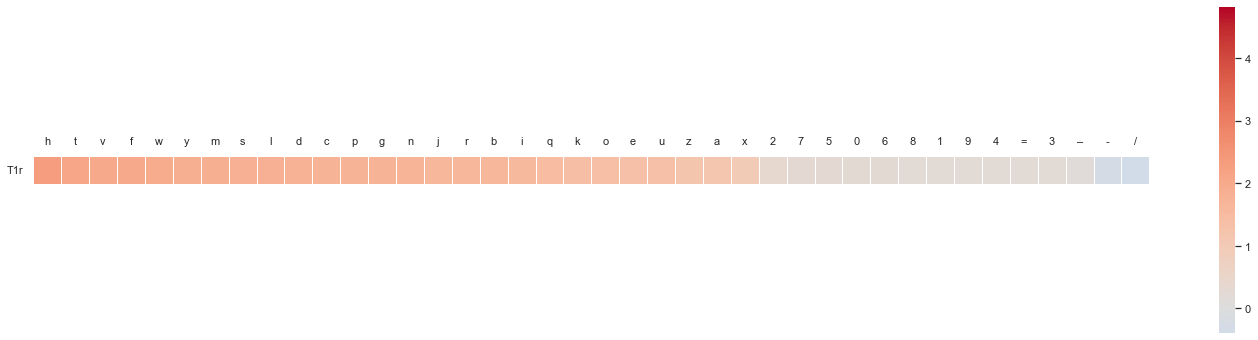

In [ ]:
util.plot([-np.sort(-V_kmeans[type_bond[1]])],[elements[i] for i in np.argsort(-V_kmeans[type_bond[1]])],[f"T{type_bond[1]+1}r"],vmax = vmax)

# Tensor Networks

In [2]:
level = "chars" # "chars", "words", "tags", "nums"

if level == "words":
    path_data = "/Users/Gianni/semiolog/wip/res_bnc/"
    filenames = [path_data+f"ng_w_{i}{'_5' if i>2 else ''}.json" for i in range(1,5)]

elif level == "tags":
    path_data = "/Users/Gianni/semiolog/wip/res_bnc/"
    filenames = [path_data+f"ng_t_{i}.json" for i in range(1,5)]

elif level == "chars":
    path_data = "./data/"
    filenames = [path_data+f"{i}_10.json" for i in range(1,5)]

punctuation = " \n\t.,;:|()[]\{\}\xa0'’‘\"”“?!"
# punctuation = "\n\t.,;:|()[]\{\}\xa0'’‘\"”“?!"
punctuation_set = set(punctuation)

In [3]:
ng1_raw = util.load_file(filenames[0])

if level in {"chars", "words"}:
    ng1 = defaultdict(int)
    for k,v in ng1_raw.items():
        if k not in punctuation:
            ng1[k.lower()] += v
else:
    ng1 = ng1_raw

In [4]:
ng2_raw, ng3_raw, ng4_raw = [util.load_file(fn) for fn in filenames[1:]]

In [5]:

if level == "chars":
    ng2 = defaultdict(int)
    for (kl,kr),v in ng2_raw.items():
        if kl not in punctuation and kr not in punctuation:
            ng2[(kl+kr).lower()] += v

    ng3 = defaultdict(int)
    for (kl,kc,kr),v in ng3_raw.items():
        if kl not in punctuation and kc not in punctuation and kr not in punctuation:
            ng3[(kl+kc+kr).lower()] += v

    ng4 = defaultdict(int)
    for (kl,kcl,kcr,kr),v in ng4_raw.items():
        if kcl in punctuation:
            if kcr in punctuation:
                if kl not in punctuation and kr not in punctuation:
                    ng2[(kl+kr).lower()] += v
            elif kl not in punctuation and kr not in punctuation:
                ng3[(kl+kcr+kr).lower()] += v
        elif kcr in punctuation:
            ng3[(kl+kcl+kr).lower()] += v
        
        if len(punctuation_set.union(" ").intersection({kl,kcl,kcr,kr})) == 0:
        # if len(punctuation_set.intersection({kl,kcl,kcr,kr})) == 0:
            ng4[(kl+kcl+kcr+kr).lower()] += v

elif level == "words":
    ng2 = defaultdict(int)
    for k,v in ng2_raw.items():
        k = k.split()
        if len(k)==2:
            kl,kr = k
            if kl not in punctuation and kr not in punctuation:
                ng2[(kl,kr)] += v

    ng3 = defaultdict(int)
    for k,v in ng3_raw.items():
        k = k.split()
        if len(k)==3:
            kl,kc,kr = k
            if kl not in punctuation and kc not in punctuation and kr not in punctuation:
                ng3[(kl,kc,kr)] += v


    ng4 = defaultdict(int)
    for k,v in ng4_raw.items():
        k = k.split()
        if len(k)==4:
            kl,kcl,kcr,kr = k
            if kcl in punctuation:
                if kcr in punctuation:
                    if kl not in punctuation and kr not in punctuation:
                        ng2[(kl,kr)] += v
                elif kl not in punctuation and kr not in punctuation:
                    ng3[(kl,kcr,kr)] += v
            elif kcr in punctuation:
                ng3[(kl,kcl,kr)] += v
            
            if len(punctuation_set.union(" ").intersection({kl,kcl,kcr,kr})) == 0:
                ng4[(kl,kcl,kcr,kr)] += v

elif level == "tags":
    ng2 = defaultdict(int)
    for k,v in ng2_raw.items():
        ng2[tuple(k.split())] += v

    ng3 = defaultdict(int)
    for k,v in ng3_raw.items():
        ng3[tuple(k.split())] += v

    ng4 = defaultdict(int)
    for k,v in ng4_raw.items():
        ng4[tuple(k.split())] += v


else:
    ng2, ng3, ng4 = [ng2_raw, ng3_raw, ng4_raw]

In [4]:
ng5 = util.load_file(path_data + "5_10_filter.json")

In [4]:
ng6 = util.load_file(path_data + "6_10_filter.json")

In [6]:
e_len = 40
elements = [k for k,v in ng1.items()]
e_len = min(len(elements),e_len)
elements = elements[:e_len]# + ["+","<",">","×"]

# elements = [str(n) for n in range(1,10)]

if level == "chars":
    elements = sorted(elements)
elements_dict = {k:i for i,k in enumerate(elements)}

print(elements[:50])

['-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '–']


In [8]:
len(ng6)

2829730

## MPS - Test On 1 Core

In [765]:
import importlib
importlib.reload(my_tn);

In [701]:
# Warning: there's a filtering threshold to build the matrix. Data is already filtered at 10
filter_thres = 40
joint_prob = ng5

order = len(next(iter(joint_prob)))
M_raw = np.zeros([e_len]*order)
for k,v in joint_prob.items():
    if v>filter_thres:
        if set(k).issubset(set(elements)):
            indeces = tuple([elements_dict[i] for i in k])
            M_raw[indeces] = v
M_norm = M_raw/M_raw.sum()
M = np.sqrt(M_norm)

In [845]:
My_MPS = my_tn.MPS(M,elements,bond_size=5, method="truncate")

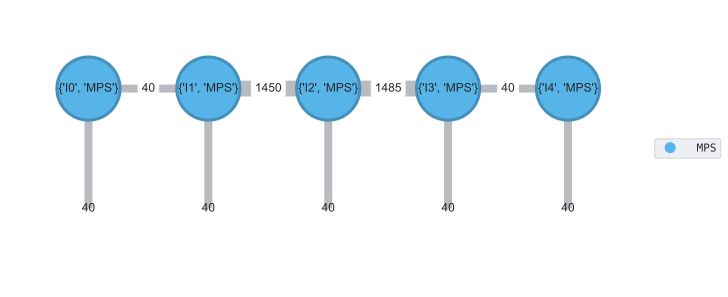

In [211]:
My_MPS.draw()

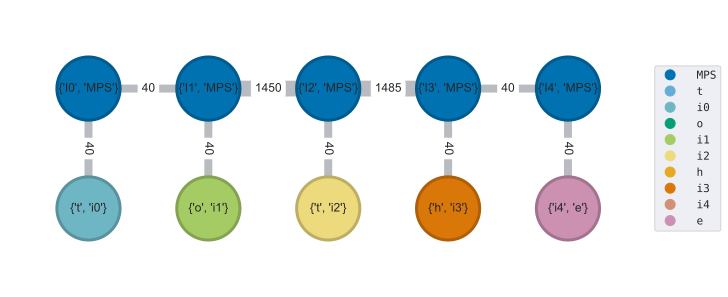

In [212]:
My_MPS.load("tothe")
# My_MPS.load(("ART","ADJ","SUBST","VERB"))

My_MPS.draw()

In [213]:
My_MPS.TN^...

0.001040042246537481

In [219]:
M[elements_dict["t"],elements_dict["o"],elements_dict["t"],elements_dict["h"],elements_dict["e"]]

0.0010400422464557565

In [217]:
M_norm[elements_dict["t"],elements_dict["o"],elements_dict["t"],elements_dict["h"],elements_dict["e"]]

1.0816878744127367e-06

In [222]:
cut = 3
TNL = set.union(*[{f"i{i}",f"I{i}"} for i in range(cut)])
TNR = set.union(*[{f"i{i}",f"I{i}"} for i in range(cut,My_MPS.order)])
contract_L = My_MPS.TN^TNL
contract_R = My_MPS.TN^TNR
signal_L = contract_L[f"I{cut-1}"].data#**2
signal_R = contract_R[f"I{cut}"].data#**2

In [223]:
signal_L@signal_R

0.001040042246537483

In [231]:
seg_signal = []
seg_score = []
for cut in range(1,My_MPS.order):
    TNL = set.union(*[{f"i{i}",f"I{i}"} for i in range(cut)])
    TNR = set.union(*[{f"i{i}",f"I{i}"} for i in range(cut,My_MPS.order)])
    contract_L = My_MPS.TN^TNL
    contract_R = My_MPS.TN^TNR
    signal_L = contract_L[f"I{cut-1}"].data
    signal_R = contract_R[f"I{cut}"].data
    seg_signal.append(np.concatenate([signal_L,signal_R]))
    # seg_score.append([signal_L.sum(),signal_R.sum()])
# seg_signal = np.array(seg_signal)
# seg_score = np.array(seg_score)
# util.plot(seg_signal.T)

In [124]:
np.concatenate([signal_R,signal_R])

array([1.26509159e-02, 2.26252292e-02, 7.58493910e-03, 9.71767010e-03,
       3.23415889e-06, 6.54264393e-03, 5.32761562e-04, 6.20111678e-03,
       1.15405579e-02, 1.50678875e-01, 1.26509159e-02, 2.26252292e-02,
       7.58493910e-03, 9.71767010e-03, 3.23415889e-06, 6.54264393e-03,
       5.32761562e-04, 6.20111678e-03, 1.15405579e-02, 1.50678875e-01])

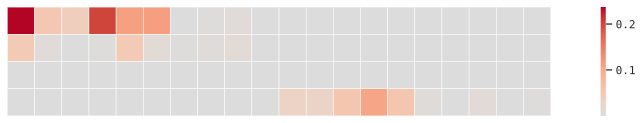

In [144]:
util.plot(seg_signal)

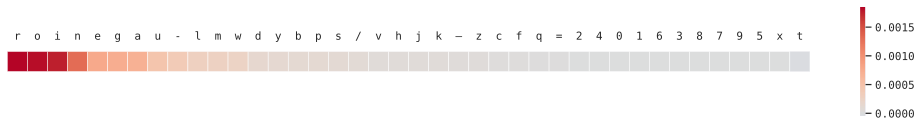

In [84]:
My_MPS.contract(3,draw=True,draw_vmax=None,draw_len = 40)

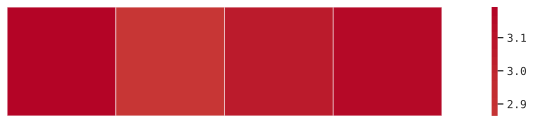

In [145]:
seg_signal = []
seg_score = []
for cut in range(My_MPS.order-1):
    TN_cut = My_MPS.TN.copy()
    TN_cut.cut_between(f"I{cut}",f"I{cut+1}",f"cut{cut}",f"cut{cut+1}")
    bond_tensor = TN_cut^...
    bond_tensor = bond_tensor.data.reshape(bond_tensor.data.size)
    seg_signal.append(bond_tensor)
    seg_score.append(entropy(bond_tensor**2))
seg_signal = np.array(seg_signal)
seg_score = np.array(seg_score)
util.plot(seg_score.T)

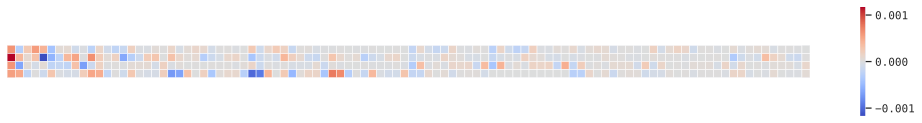

In [148]:
util.plot(seg_signal)

In [26]:

bla = My_MPS.TN.contract_tags([f"I{i}" for i in range(2)]+[f"i{i}" for i in range(2)])

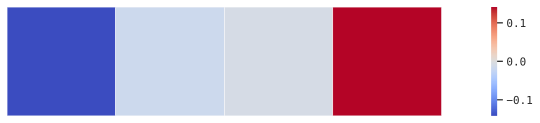

In [31]:
util.plot(bla["I0"].data)

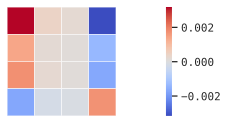

In [22]:
util.plot(bla.data)

In [ ]:
cut = 2 # Choose which index to cut

MPS = qtn.TensorNetwork(My_MPS.TN["MPS"])
MPS_H = MPS.H
MPS_H.drop_tags("MPS")
MPS_H.add_tag("MPSh")
cut_tensor = MPS_H[f"I{cut}"]
cut_tensor.reindex({ind:(ind if ind!= f"k{cut}" else "cut") for i,ind in enumerate(cut_tensor.inds)}, inplace=True)
MPS_tn = MPS & MPS_H
MPS_tn.draw(show_inds=True)

## MPS - Iterating Central Core

In [24]:
# Test over an MPS made of the first and last tensor of the previous MPS and as many copies of the central tensor of the previous MPS as necessary to process sequences of arbitrary length

MPS_G = my_tn.MPS_G(My_MPS)

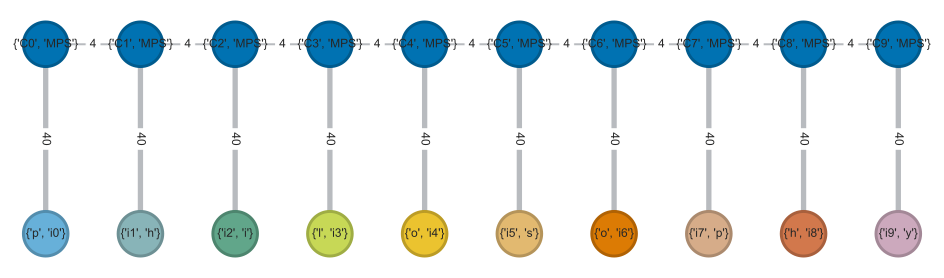

In [25]:
MPS_G.load("philosophy")
MPS_G.draw()

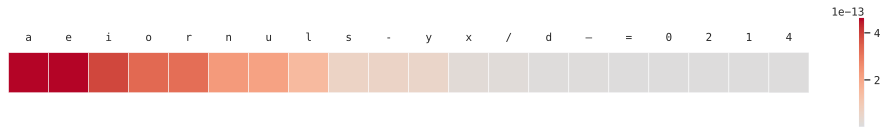

In [28]:
MPS_G.contract(0,draw=True,draw_vmax=None)

## Full Tensor - Tracing Out 1 Edge

In [397]:
sns.set(
    rc = {'figure.figsize':(10,10)},
    font="monospace"
    )

In [704]:
M_t = qtn.Tensor(M, inds=[f"k{i}" for i in range(M.ndim)], tags = "M")
M_tH = M_t.H
M_tH.drop_tags("M")
M_tH.add_tag("Mh")


In [716]:
((M_tH & My_MPS.TN) ^ all) ** 2

0.35193453242135175

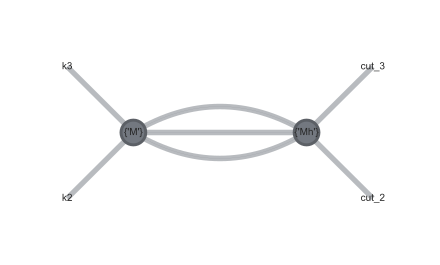

In [513]:
cut = 3 # Choose which index to cut
M_tH.reindex({ind:(ind if i!= cut else f"cut_{cut}") for i,ind in enumerate(M_tH.inds)}, inplace=True)
M_tn = M_t & M_tH
M_tn.draw(
    fix = {
        "M": (0,0),
        "Mh": (1,0) 
    }
)

In [520]:
M_contract = M_tn^...
M_contract.draw()

In [ ]:
util.plot(M_contract.data,elements,elements)

Done


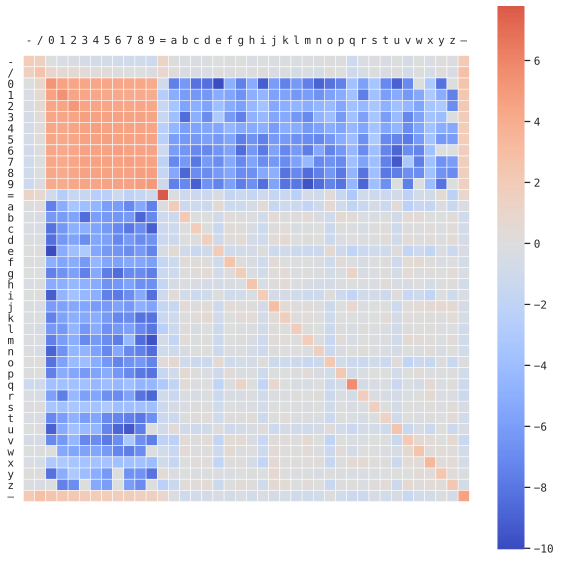

In [391]:
M_pmi = util.pmi(M_contract.data,type_pmi="pmi").toarray()
util.plot(M_pmi,elements,elements)

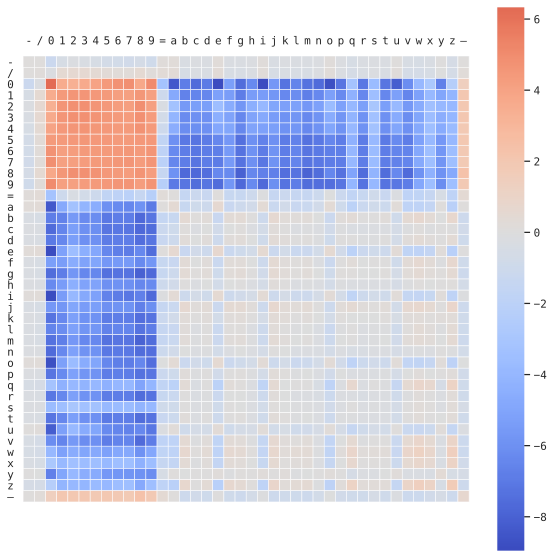

In [392]:
u,s,vh = np.linalg.svd(M_pmi)
truncate = 3
M_svd_t = u[:,:truncate] @ np.diag(s[:truncate]) @ vh[:truncate]
util.plot(M_svd_t,elements,elements)

In [393]:
util.hierarchical_matrix(M_pmi,elements,elements, method="ward")

interactive(children=(IntSlider(value=2, description='row_n', max=40, min=1), IntSlider(value=2, description='…

In [394]:
util.hierarchical_matrix(M_svd_t,elements,elements, method="ward")

interactive(children=(IntSlider(value=2, description='row_n', max=40, min=1), IntSlider(value=2, description='…

## Full Tensor - Tracing Out 2 Edges for Dual/Orthogonal Types

In [522]:
M_t = qtn.Tensor(M, inds=[f"k{i}" for i in range(M.ndim)], tags = "M")
M_tH = M_t.H
M_tH.drop_tags("M")
M_tH.add_tag("Mh")

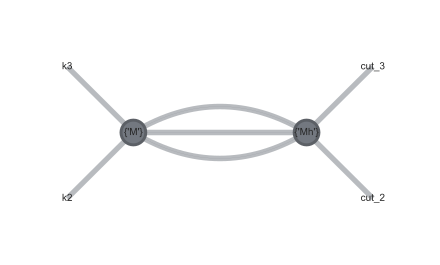

In [523]:
cut = 2 # Choose which index to cut
M_tH.reindex({ind:(ind if i!= cut else f"cut_{cut}") for i,ind in enumerate(M_tH.inds)}, inplace=True)
M_tn = M_t & M_tH
cut = 3 # Choose which index to cut
M_tH.reindex({ind:(ind if i!= cut else f"cut_{cut}") for i,ind in enumerate(M_tH.inds)}, inplace=True)

M_tn = M_t & M_tH
M_tn.draw(
    fix = {
        "M": (0,0),
        "Mh": (1,0) 
    }
)

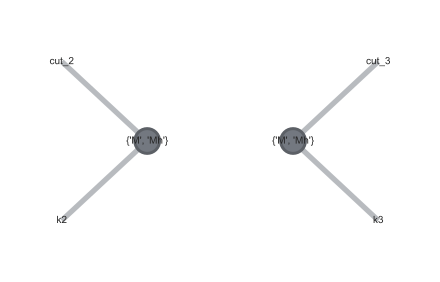

In [545]:
M_contract = M_tn^...
M_dual = M_contract.split(["k2","cut_2"],max_bond=1)
M_dual.draw()

In [546]:
M_dual.tensors

(Tensor(shape=(40, 40, 1), inds=('k2', 'cut_2', '_b29225AAABV'), tags=oset(['M', 'Mh'])),
 Tensor(shape=(1, 40, 40), inds=('_b29225AAABV', 'k3', 'cut_3'), tags=oset(['M', 'Mh'])))

In [547]:
bond_n = 0
M_l = M_dual.tensors[0].data[:,:,bond_n]
M_r = M_dual.tensors[1].data[bond_n,:,:]

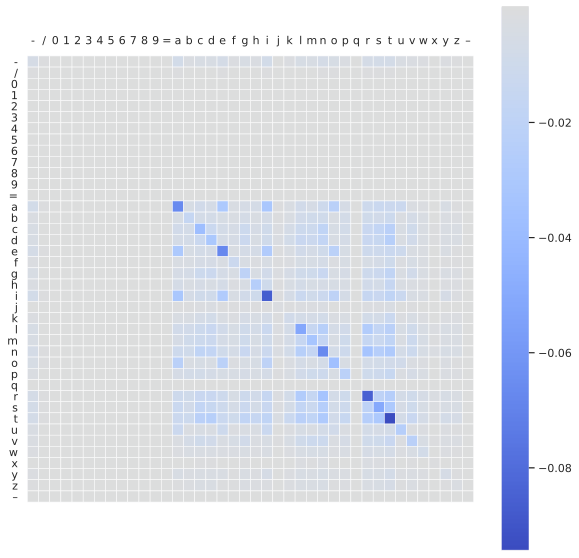

In [548]:
util.plot(M_l,elements,elements)

Done


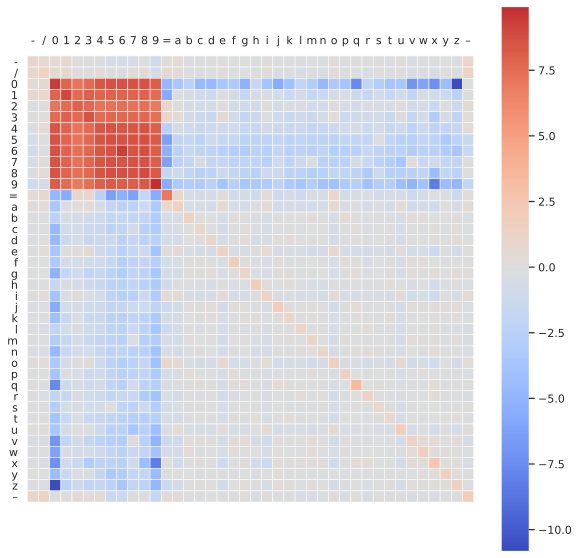

In [550]:
M_l_pmi = util.pmi(M_l,type_pmi="pmi").toarray()
util.plot(M_l_pmi,elements,elements)

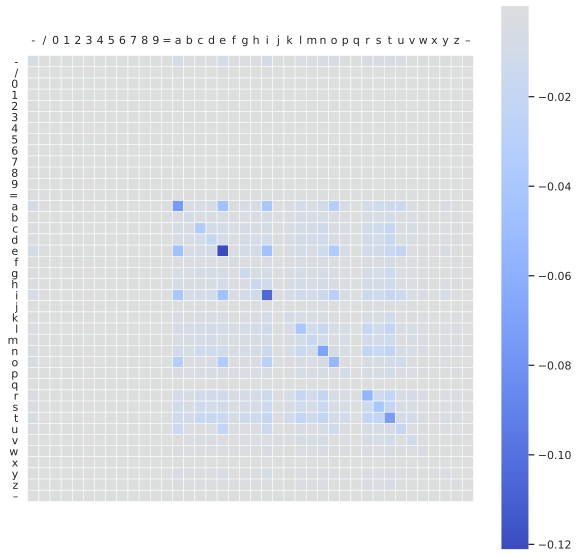

In [549]:
util.plot(M_r.data,elements,elements)

Done


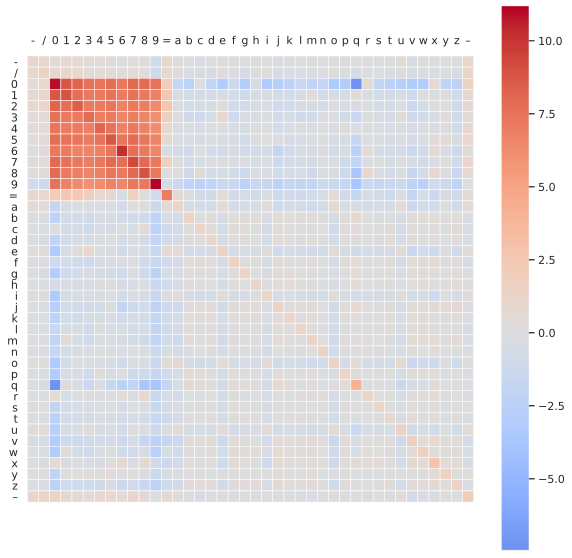

In [532]:
M_r_pmi = util.pmi(M_r,type_pmi="pmi").toarray()
util.plot(M_r_pmi,elements,elements)

In [551]:
util.hierarchical_matrix(M_l_pmi,elements,elements, method="ward")

interactive(children=(IntSlider(value=2, description='row_n', max=40, min=1), IntSlider(value=2, description='…

## MPS - Tracing Out 1 Edge

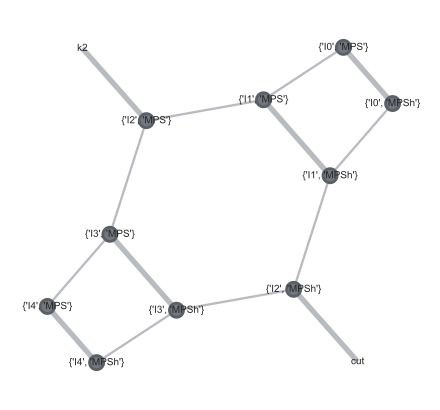

In [471]:
cut = 2 # Choose which index to cut

MPS = qtn.TensorNetwork(My_MPS.TN["MPS"])
MPS_H = MPS.H
MPS_H.drop_tags("MPS")
MPS_H.add_tag("MPSh")
cut_tensor = MPS_H[f"I{cut}"]
cut_tensor.reindex({ind:(ind if ind!= f"k{cut}" else "cut") for i,ind in enumerate(cut_tensor.inds)}, inplace=True)
MPS_tn = MPS & MPS_H
MPS_tn.draw(show_inds=True)

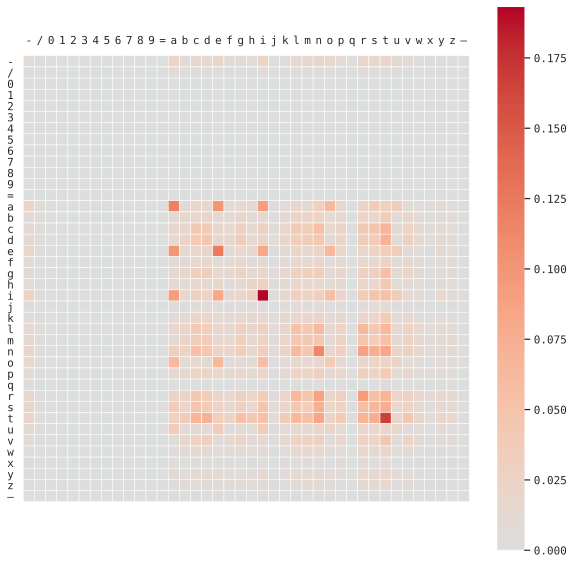

In [474]:
MPS_contract = MPS_tn^...
util.plot(MPS_contract.data,elements,elements)

In [480]:
elements_dict["7"]

9

In [499]:
matrix = MPS_contract.data
num_skipgrams = matrix.sum()
sum_over_contexts = np.array(matrix.sum(axis=1)).flatten()
sum_over_terms = np.array(matrix.sum(axis=0)).flatten()
tok_terms = 9
tok_context = 9
sg_count = matrix[tok_terms,tok_context]
nwc = sg_count
Pwc = nwc / num_skipgrams
nw = sum_over_contexts[tok_terms]
Pw = nw / num_skipgrams
nc = sum_over_terms[tok_context]
Pc = nc / num_skipgrams
pmi = np.log(Pwc/(Pw*Pc))
pmi

3.1980647597015674

In [510]:
matrix = MPS_contract.data**2
num_skipgrams = (matrix).sum()
np.log(((matrix[8,8])/num_skipgrams)/(((matrix.sum(axis=1)[8])/num_skipgrams)**2))

1.6934718883696607

In [497]:
(MPS_contract.data).trace()

1.2543076788147491

In [491]:
MPS_pmi[9,9]

6.058926538248716

In [498]:
MPS_contract.data.sum()

13.15495378012076

Done


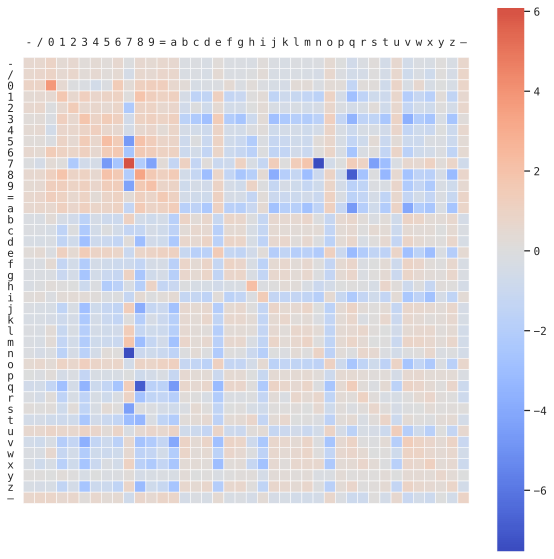

In [477]:
MPS_pmi = util.pmi(MPS_contract.data**2,type_pmi="pmi").toarray()
util.plot(MPS_pmi,elements,elements)

In [478]:
util.hierarchical_matrix(MPS_pmi,elements,elements, method="ward")

interactive(children=(IntSlider(value=2, description='row_n', max=40, min=1), IntSlider(value=2, description='…

## MPS - Train

In [5]:
from quimb.tensor.optimize import TNOptimizer

In [9]:
# Warning: there's a filtering threshold to build the matrix. Data is already filtered at 10
filter_thres = 10
joint_prob = ng6

order = len(next(iter(joint_prob)))
M_raw = np.zeros([e_len]*order)
for k,v in joint_prob.items():
    if v>filter_thres:
        if set(k).issubset(set(elements)):
            indeces = tuple([elements_dict[i] for i in k])
            M_raw[indeces] = v
M_norm = M_raw/M_raw.sum()
M = np.sqrt(M_norm)

L = M.ndim

In [10]:
target = qtn.Dense1D(M.reshape(M.size), phys_dim=e_len)
print(target)

Dense1D([
    Tensor(shape=(40, 40, 40, 40, 40, 40), inds=('k0', 'k1', 'k2', 'k3', 'k4', 'k5'), tags=oset(['I0', 'I1', 'I2', 'I3', 'I4', 'I5'])),
], L=6, max_bond=40)


In [11]:
def normalize_state(psi):
    return psi / (psi.H @ psi) ** 0.5
def negative_overlap(psi, target):
    return - (psi.H @ target) ** 2  # minus so as to minimize

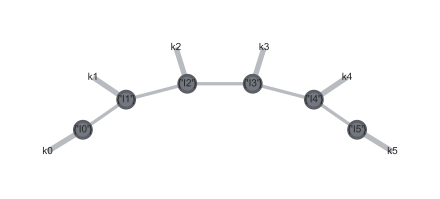

In [14]:
bond_dim = 10
mps = qtn.MPS_rand_state(L, bond_dim, phys_dim=e_len)
mps.draw()

In [15]:
optmzr = TNOptimizer(
    mps,                                # our initial input, the tensors of which to optimize
    loss_fn=negative_overlap,
    norm_fn=normalize_state,
    loss_constants={'target': target},  # this is a constant TN to supply to loss_fn
    loss_target=None,
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer= 'adam',#'L-BFGS-B',               # supplied to scipy.minimize
)

In [16]:
mps_opt = optmzr.optimize(100)  # perform ~100 gradient descent steps

  0%|          | 0/100 [00:00<?, ?it/s]

: 

: 

In [846]:
((My_MPS.TN.H & target) ^ all) ** 2

0.2487236900774696

In [850]:
((mps_opt.H & target) ^ all) ** 2

0.21300442888364654

In [851]:
mps_train = my_tn.MPS(mps_opt,elements,method="from_mps")

In [870]:
exp = "74837"
mps_train.load(exp)
My_MPS.load(exp)

In [871]:
(mps_train.TN^all)**2

6.12365824856567e-39

In [872]:
c1,c2,c3,c4,c5 = exp
M[elements_dict[c1],elements_dict[c2],elements_dict[c3],elements_dict[c4],elements_dict[c5]]**2

2.3391556543282745e-09

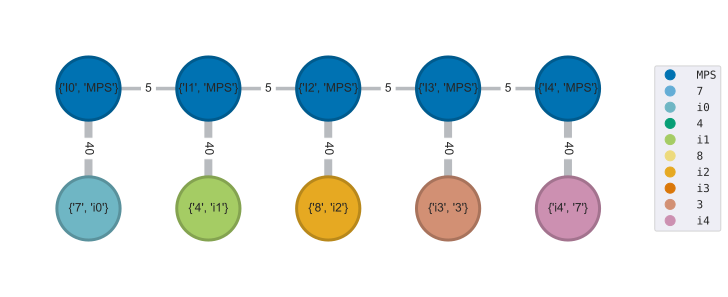

In [873]:
mps_train.draw()

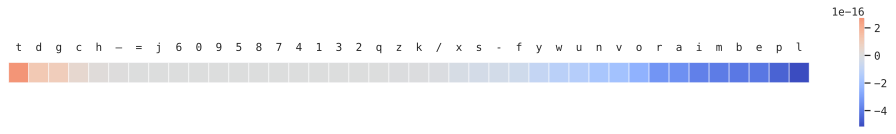

In [874]:
mps_train.contract(2,draw=True,draw_vmax=None,draw_len = 40)

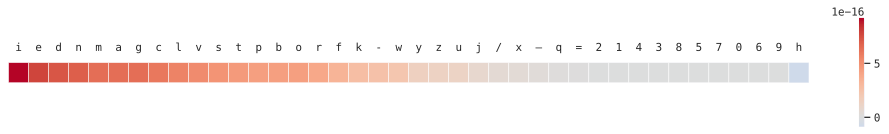

In [875]:
My_MPS.contract(2,draw=True,draw_vmax=None,draw_len = 40)